# Load Modeuls and Set `matplotlib` Parameters

In [1]:
# Copyright 2023 wngfra.
# SPDX-License-Identifier: Apache-2.0

%load_ext autoreload
%autoreload 2

import importlib
import os
from typing import Optional

import matplotlib
import matplotlib.pyplot as plt
import nengo
import numpy as np
import pandas as pd
from BarGenerator import BarGenerator, gen_transform
from IPython.lib.deepreload import reload
from learning_rules import SDSP
from nengo.utils.matplotlib import rasterplot
from nengo_extras.graphviz import net_diagram
from nengo_extras.matplotlib import imshow
from nengo_extras.plot_spikes import plot_spikes
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

%matplotlib widget

fc = "black"

font = {"weight": "normal", "size": 25}
matplotlib.rc("font", **font)
matplotlib.rc("xtick", color=fc)
matplotlib.rc("ytick", color=fc)
matplotlib.rc("text", color=fc)

2023-09-13 10:38:51.399709: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-13 10:38:51.431046: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-13 10:38:51.431852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 10:38:51.993629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-13 10:38:53.394898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-13 10:38:54.126568: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned 

# Spike-Driven Synaptic Dynamics
1. The calcium variable $C(t)$ is a function of postsynaptic spiking activity with a long time constant, $$\frac{dC(t)}{dt} = -\frac{1}{\tau_C} C(t) + J_s,$$ where $J_s = J_C \sum_i \delta(t - t_i)$ and $$\frac{dJ_s}{dt} = - \frac{J_s}{\tau_J}.$$
3. The $X(t)$ is restricted to $X_{min} \leq X \leq X_{max}$ and is dependent on $C(t)$. When a presynaptic spike arrives at time $t_{pre}$, the variable $X$ updates by
$$X \rightarrow X + a \quad \text{if} \quad V(t_{pre}) > \theta_V \quad \text{and} \quad \theta^l_{up} < C(t_{pre}) < \theta^h_{up}$$
$$X \rightarrow X - b \quad \text{if} \quad V(t_{pre}) \leq \theta_V \quad \text{and} \quad \theta^l_{down} < C(t_{pre}) < \theta^h_{down}$$
4. When there is no presynaptic spiking acvitity or the above conditions are not met, the internal state $X$ drifts towards the bistable states according to
$$\frac{dX}{dt} = \alpha \quad \text{if} \quad X > \theta_X$$
$$\frac{dX}{dt} = -\beta \quad \text{if} \quad X \leq \theta_X$$
5. At the time $t_{pre}$ the synaptic efficacy (weight) is updated to $J_{ex}$ if $X > \theta_X$ or instead $J_{in}$ if $X \leq \theta_X$. 

# Create Nengo Network and Run Supervised Learning

In [2]:
 # Copyright 2023 wngfra.
# SPDX-License-Identifier: Apache-2.0
import os

import nengo
import numpy as np
from BarGenerator import BarGenerator, gen_transform
from IPython.lib.deepreload import reload
from learning_rules import SDSP


# Define network parameters
stim_shape = (12, 12)
stim_size = np.prod(stim_shape)
num_samples = 12
repeats = 5

# Prepare dataset
bg = BarGenerator(stim_shape)
X_in, y_in = bg.generate_samples(
    num_samples=num_samples,
    dim=(3, 10),
    shift=(0, 0),
    start_angle=0,
    step=180 / num_samples,
    repeats=repeats,
    add_test=True,
)

# Simulation parameters
dt = 1e-3
n_output = num_samples
decay_time = 0.2
presentation_time = 3 + decay_time
duration = X_in.shape[0] * presentation_time
train_duration = repeats / (repeats + 1) * duration
sample_every = 10 * dt
learning_rule_option = {
    "SDSP": SDSP(
        J_C=35,
        tau_c=6e-2,
        tau_j=2e-2,
        X_coeff=(0.1, 0.1, 3.5, 3.5),  # (a, b, alpha, beta)
        theta_coeff=(13, 3, 4, 3),  # (theta_hup, theta_lup, theta_hdown, theta_ldown)
    ),
}

# Default neuron parameters
max_rates = 60  # Hz
amp = 1.0

tau_rc = 0.02
rate_target = max_rates * amp  # must be in amplitude scaled units
default_neuron = nengo.AdaptiveLIF(amplitude=amp, tau_rc=tau_rc)
default_rates = nengo.dists.Choice([rate_target])
default_intercepts = nengo.dists.Choice([0])
default_encoders = nengo.dists.ScatteredHypersphere(surface=True)


def stim_func(t):
    Xid = int(t / presentation_time) % len(X_in)
    stage = t - int(t / presentation_time) * presentation_time
    sample = X_in[Xid].ravel()
    if stage <= presentation_time - decay_time:
        return sample
    else:
        return np.zeros_like(sample)


def target_func(t):
    target = y_in[int(t / presentation_time) % len(y_in)]
    stage = t - int(t / presentation_time) * presentation_time
    spike = np.zeros(n_output + 1)
    if stage <= presentation_time - decay_time:
        n_target = int(target / (180 / n_output))
        spike[n_target] = 1
        spike[-1] = 1.0 if t < train_duration else 0.0
    return spike


# Define layers
layer_confs = [
    dict(
        name="stimulus",
        neuron=None,
        output=stim_func,
    ),
    dict(
        name="target",
        neuron=None,
        output=target_func,
    ),
    dict(
        name="input",
        n_neurons=stim_size,
        dimensions=1,
    ),
    dict(
        name="output",
        n_neurons=n_output,
        dimensions=1,
    ),
    dict(
        name="switch",
        neuron=None,
        output=lambda t: 1.0 if t < train_duration else 0.0,
    ),
]

# Define connections
conn_confs = [
    # Input/Visual connections
    dict(
        pre="stimulus",
        post="input_neurons",
        transform=1,
        synapse=0,
    ),
    dict(
        pre="input_neurons",
        post="output_neurons",
        transform=gen_transform(),
        learning_rule=learning_rule_option["SDSP"],
        synapse=0,
    ),
    dict(
        pre="output_neurons",
        post="output_neurons",
        transform=1*(np.eye(n_output) - 1),
        synapse=1e-3,
    ),
]


learning_confs = [
    dict(
        pre="switch",
        post="input_neurons2output_neurons",
    ),
]

# Create the Nengo model
with nengo.Network(label="tacnet_train", seed=1) as model:
    layers = dict()
    connections = dict()
    probes = dict()

    # Create layers
    for k, layer_conf in enumerate(layer_confs):
        layer_conf = dict(layer_conf)  # Copy configuration
        name = layer_conf.pop("name")
        n_neurons = layer_conf.pop("n_neurons", 1)
        dimensions = layer_conf.pop("dimensions", 1)
        encoders = layer_conf.pop("encoders", default_encoders)
        max_rates = layer_conf.pop("max_rates", default_rates)
        radius = layer_conf.pop("radius", 1.0)
        neuron_type = layer_conf.pop("neuron", default_neuron)
        on_chip = layer_conf.pop("on_chip", False)
        block = layer_conf.pop("block", None)
        output = layer_conf.pop("output", None)
        size_in = layer_conf.pop("size_in", None)

        assert len(layer_conf) == 0, "Unused fields in {}: {}".format(
            [name], list(layer_conf)
        )

        if neuron_type is None:
            assert not on_chip, "Nodes can only be run off-chip"

            layer = nengo.Node(output=output, size_in=size_in, label=name)
            layers[name] = layer
            probe = nengo.Probe(
                layer, synapse=0.01, sample_every=sample_every, label="%s_probe" % name
            )
            probes[name] = probe
        else:
            layer = nengo.Ensemble(
                n_neurons,
                dimensions=dimensions,
                radius=radius,
                encoders=encoders,
                intercepts=default_intercepts,
                neuron_type=neuron_type,
                max_rates=max_rates,
                normalize_encoders=True,
                label=name,
            )
            layers[name] = layer
            layers[name + "_neurons"] = layer.neurons

            # Add a probe so we can measure individual layer rates
            probe = nengo.Probe(
                layer, synapse=0.01, sample_every=sample_every, label="%s_probe" % name
            )
            probes[name] = probe
            probe = nengo.Probe(
                layer.neurons,
                sample_every=sample_every,
                synapse=0.01,
                label="%s_neurons_probe" % name,
            )
            probes[name + "_neurons"] = probe
            probe = nengo.Probe(
                layer.neurons,
                "output",
                sample_every=sample_every,
                synapse=0.01,
            )
            probes[name + "_voltages"] = probe

    for k, conn_conf in enumerate(conn_confs):
        conn_conf = dict(conn_conf)
        pre = conn_conf.pop("pre")
        post = conn_conf.pop("post")
        dim_in = conn_conf.pop("dim_in", None)
        dim_out = conn_conf.pop("dim_out", None)
        synapse = conn_conf.pop("synapse", None)
        solver = conn_conf.pop("solver", None)
        transform = conn_conf.pop("transform", None)
        learning_rule = conn_conf.pop("learning_rule", None)
        name = "{}2{}".format(pre, post)
        function = conn_conf.pop("function", None)

        assert len(conn_conf) == 0, "Unused fields in {}: {}".format(
            [name], list(layer_conf)
        )
        if dim_in is None:
            pre_conn = layers[pre]
        else:
            pre_conn = layers[pre][dim_in]
        if dim_out is None:
            post_conn = layers[post]
        else:
            post_conn = layers[post][dim_out]
        if callable(transform):
            transform = transform((post_conn.size_in, pre_conn.size_in))
        conn = nengo.Connection(
            pre_conn,
            post_conn,
            function=function,
            transform=transform,
            synapse=synapse,
            label=name,
        )
        if solver:
            conn.solver = solver
        if learning_rule:
            conn.learning_rule_type = learning_rule
            try:
                name_ = name + "_X"
                probes[name_] = nengo.Probe(
                    conn.learning_rule,
                    "X",
                    synapse=0.01,
                    sample_every=sample_every,
                    label=f"{name_}",
                )
                name_ = name + "_C"
                probes[name_] = nengo.Probe(
                    conn.learning_rule,
                    "C",
                    synapse=0.01,
                    sample_every=sample_every,
                    label=f"{name_}",
                )
            except:
                pass
        connections[name] = conn

        # Probe weights
        name_ = name + "_weights"
        probes[name_] = nengo.Probe(
            conn,
            "weights",
            synapse=0.01,
            sample_every=sample_every,
            label=f"{name_}",
        )

    # Connect learning rule
    for k, learning_conf in enumerate(learning_confs):
        learning_conf = dict(learning_conf)
        pre = learning_conf.pop("pre")
        post = learning_conf.pop("post")
        transform = learning_conf.pop("transform", 1)
        nengo.Connection(
            layers[pre],
            connections[post].learning_rule,
            transform=transform,
        )


def main(plot=False, savedata=False):
    with nengo.Simulator(model, dt=dt, optimize=True) as sim:
        sim.run(duration)

    if savedata:
        simdata = dict(
            trange=sim.trange(sample_every=sample_every),
            target=sim.data[probes["target"]],
            input=sim.data[probes["input_neurons"]],
            output=sim.data[probes["output_neurons"]],
            output_voltage=sim.data[probes["output_voltages"]],
            weight=sim.data[probes["input_neurons2output_neurons_weights"]],
            X=sim.data[probes["input_neurons2output_neurons_X"]],
            C=sim.data[probes["input_neurons2output_neurons_C"]],
        )
        return simdata


simdata = main(plot=True, savedata=True)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

### Plot Simulation Results

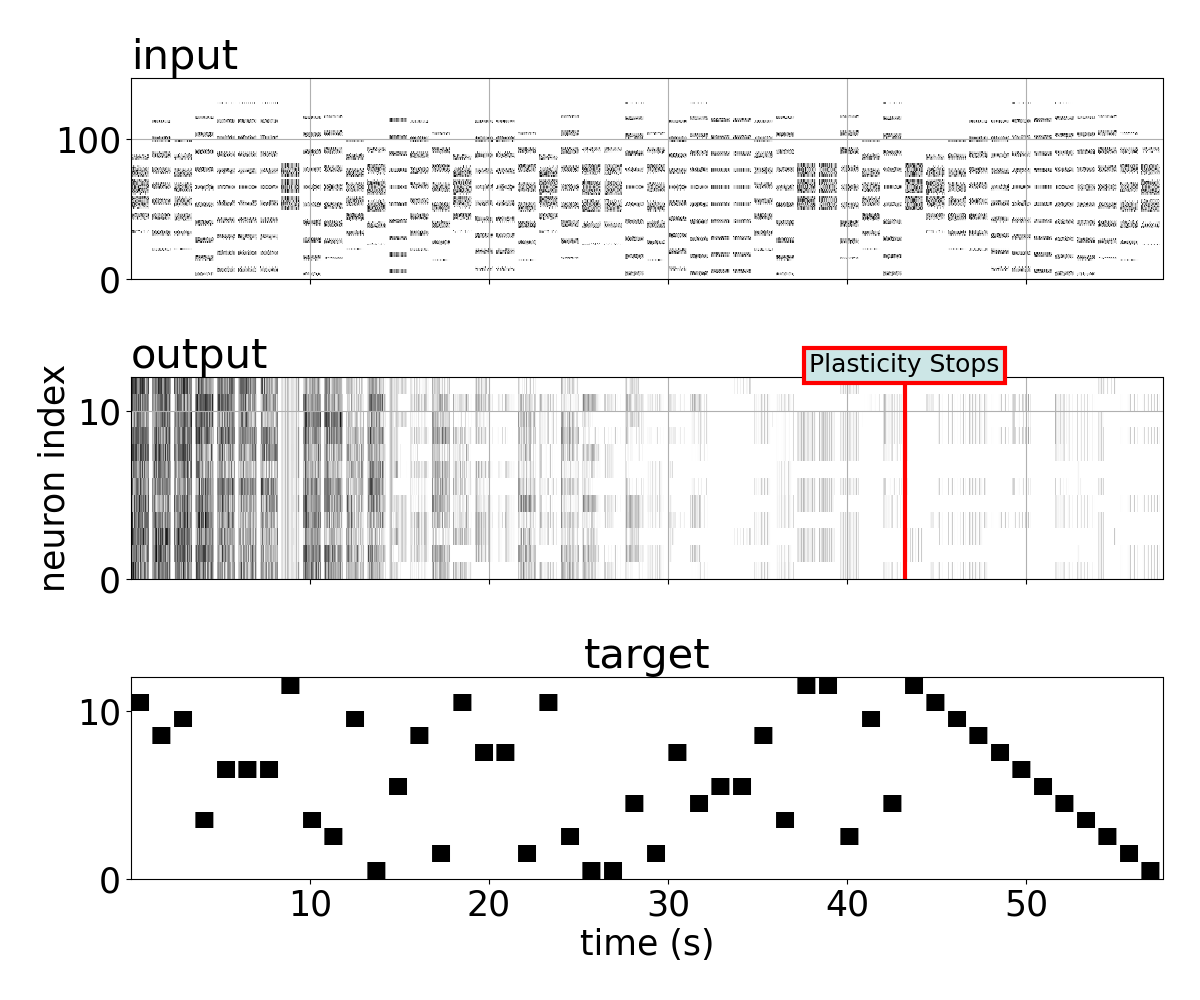

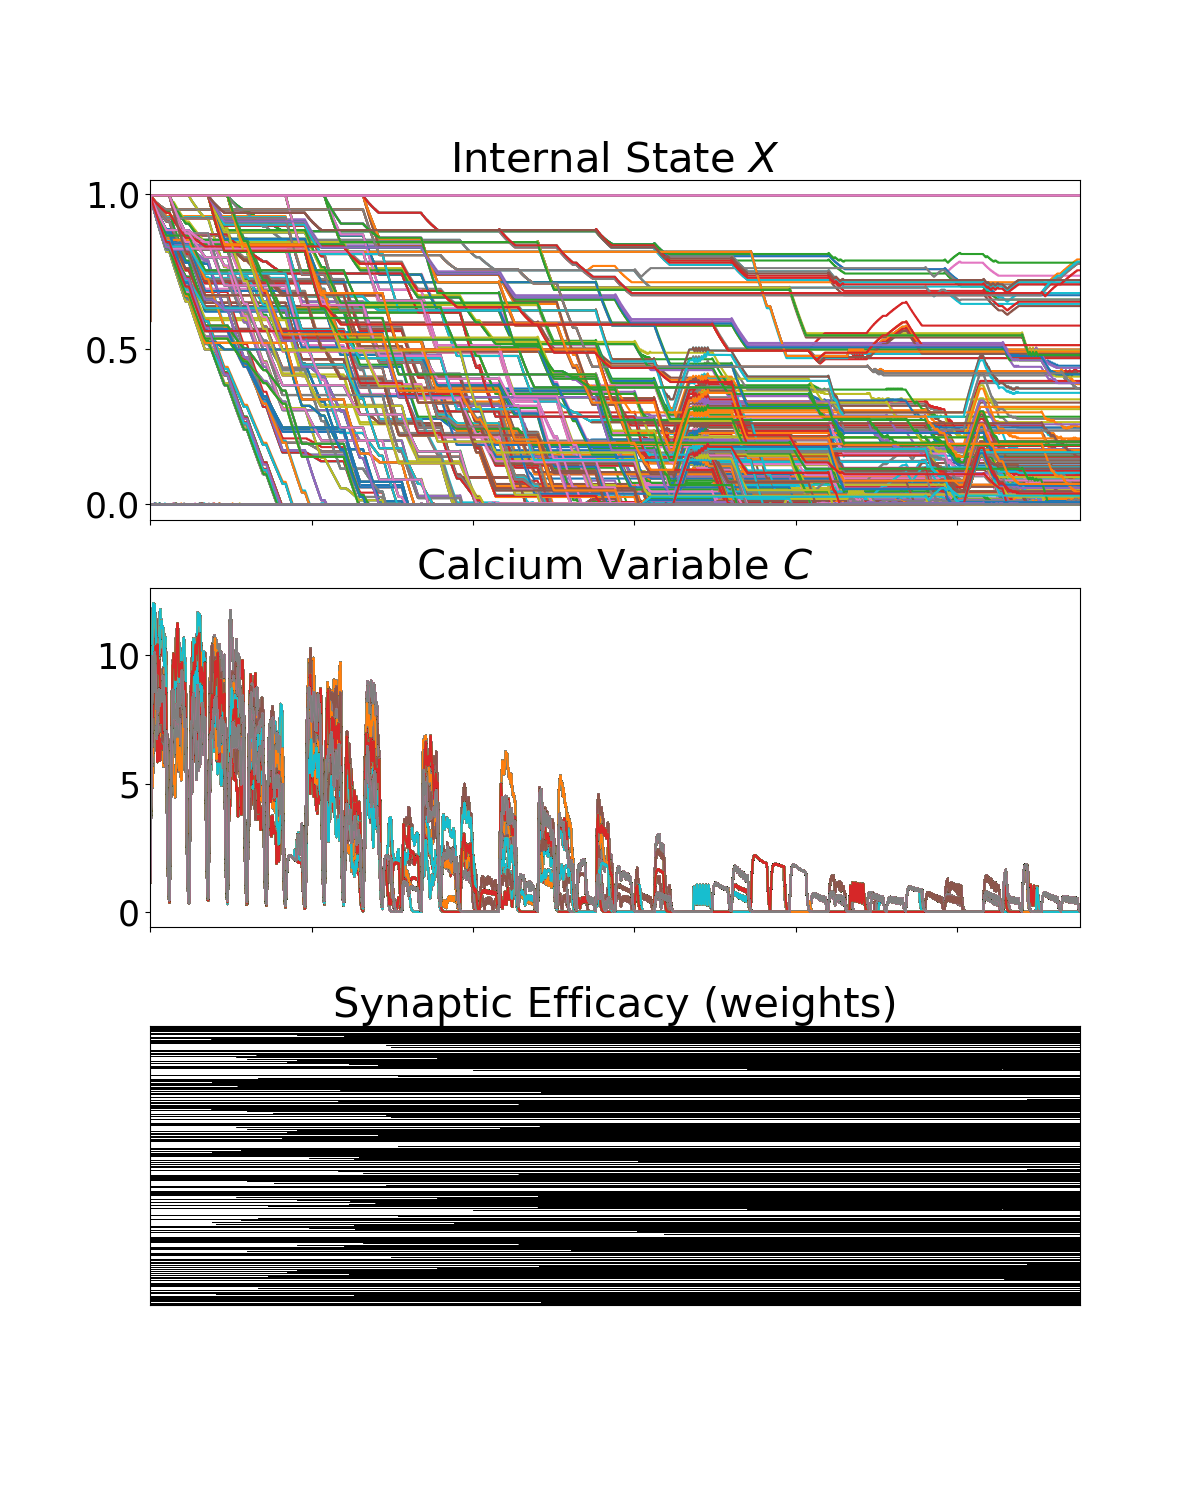

In [36]:
plt.close("all")

# Plot spiking activities
_, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for i, name in enumerate(["input", "output"]):
    plot_spikes(simdata["trange"], simdata[name], ax=axs[i])
    axs[i].set_title(name, loc="left")
    axs[i].grid()
axs[1].set_ylabel("neuron index")
axs[1].vlines(train_duration, 0, n_output, "r", linewidth=3)
bbox_props = dict(fc=(0.8, 0.9, 0.9), ec="r", lw=3)
axs[1].text(
    train_duration,
    n_output,
    "Plasticity Stops",
    ha="center",
    va="bottom",
    rotation=0,
    size=18,
    bbox=bbox_props,
)
plot_spikes(simdata["trange"], simdata["target"][:, :-1], ax=axs[2])
axs[2].set_title(f"target")
plt.xlabel(f"time (s)")
plt.tight_layout()
plt.show(block=False)

# Plot synaptic variables
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
axs[0].plot(
    simdata["X"].reshape(-1, n_output * stim_size)[:, :],
)
axs[0].set_title(r"Internal State $X$")
axs[1].plot(
    simdata["C"].reshape(-1, n_output * stim_size)[:, :],
)
axs[1].set_title(r"Calcium Variable $C$")
imshow(
    simdata["weight"].reshape(-1, n_output * stim_size).T,
    ax=axs[2],
)
axs[2].set_title("Synaptic Efficacy (weights)")
plt.show(block=False)

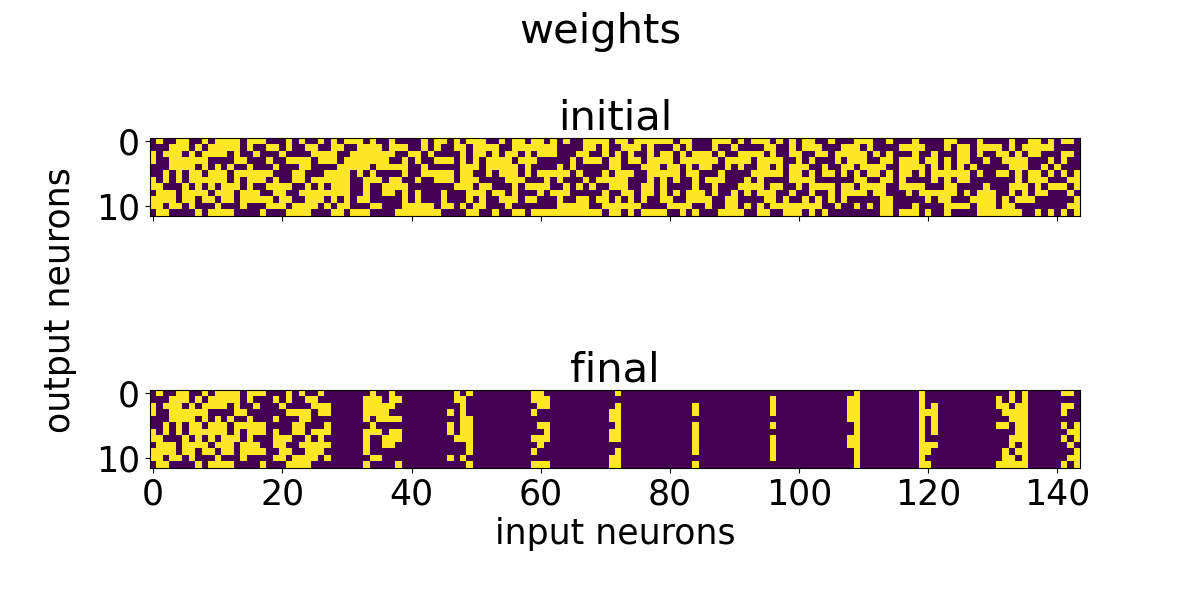

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
axs[0].imshow(simdata["weight"][0, :, :])
axs[0].set_title("initial")
axs[1].imshow(simdata["weight"][-1, :, :])
axs[1].set_title("final")
fig.text(0.05,0.5, "output neurons", ha="center", va="center", rotation=90)
plt.xlabel("input neurons")
plt.suptitle("weights")
plt.show()

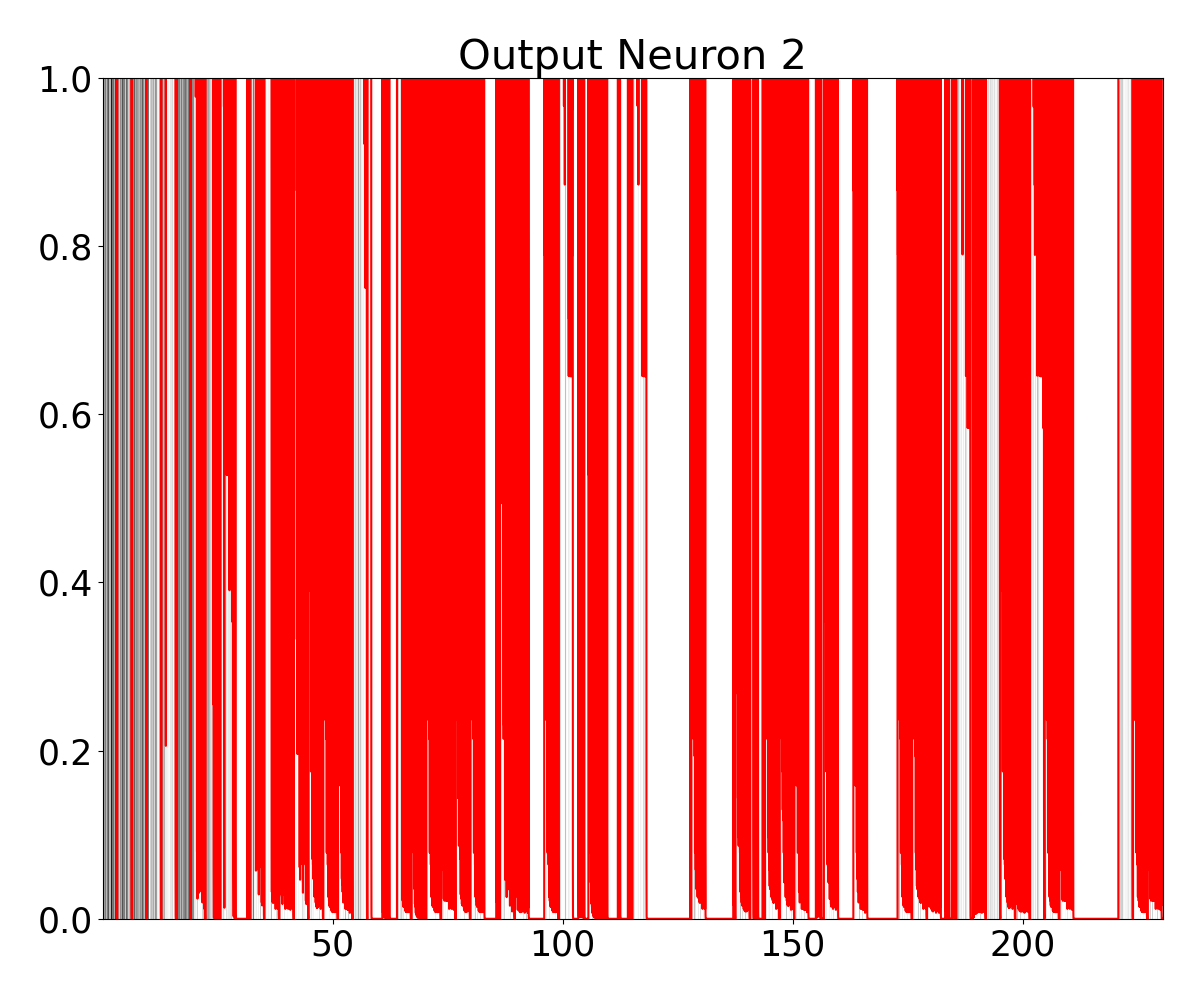

In [4]:
# Plot membrane potentials
nid = 1
_, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(simdata["trange"], simdata["output_voltage"][:, nid], "r")
plot_spikes(simdata["trange"], simdata["output"][:, nid : nid + 1], ax=ax)

ax.set_title(f"Output Neuron {nid + 1}")

plt.tight_layout()
plt.show(block=False)

# Visualize Classification of Stimulus Patterns

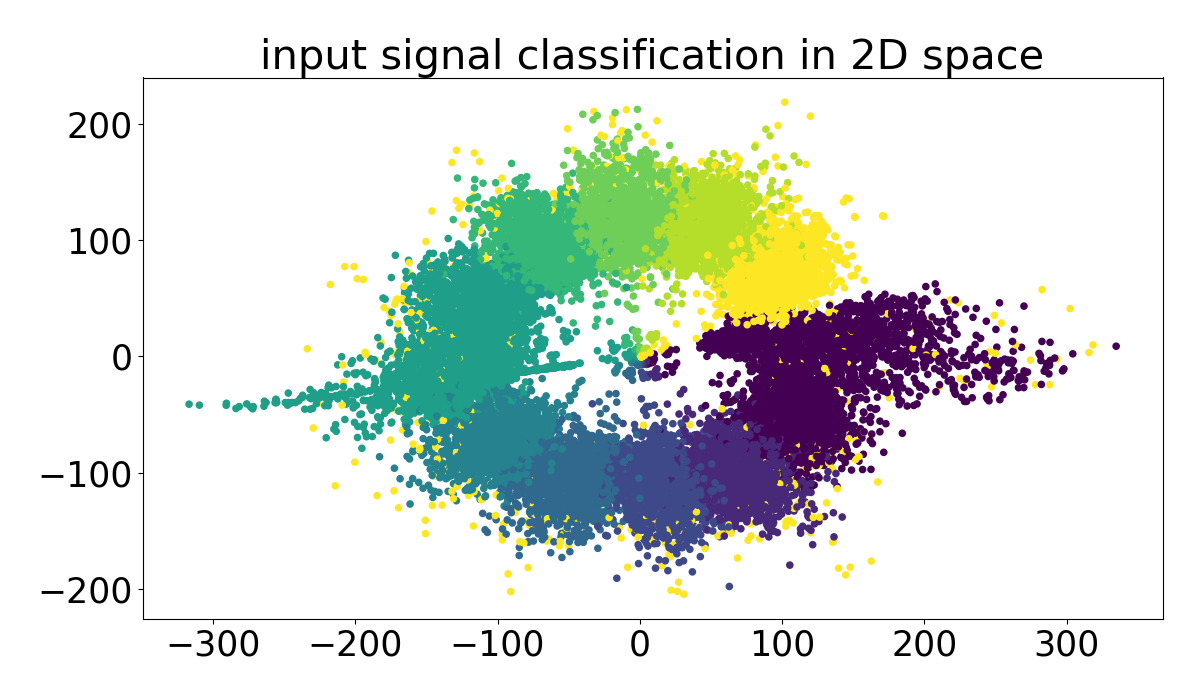

In [5]:
n_neighbours = 10
clf = KNeighborsClassifier(n_neighbors=n_neighbours, weights="distance")
X = simdata["input"]
y = np.argmax(simdata["target"], axis=1)
X_train = X[: int(0.5 * X.shape[0])]
y_train = y[: int(0.5 * X.shape[0])]
X_test = X[int(0.5 * X.shape[0]) :]
y_test = y[int(0.5 * X.shape[0]) :]

pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cmap = matplotlib.colormaps["viridis"].resampled(n_neighbours)

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()
ax.scatter(*X_new.T, c=y, cmap=cmap, s=20)
plt.title("input signal classification in 2D space")
plt.tight_layout()
plt.show()

# Visualize Input Stimuli

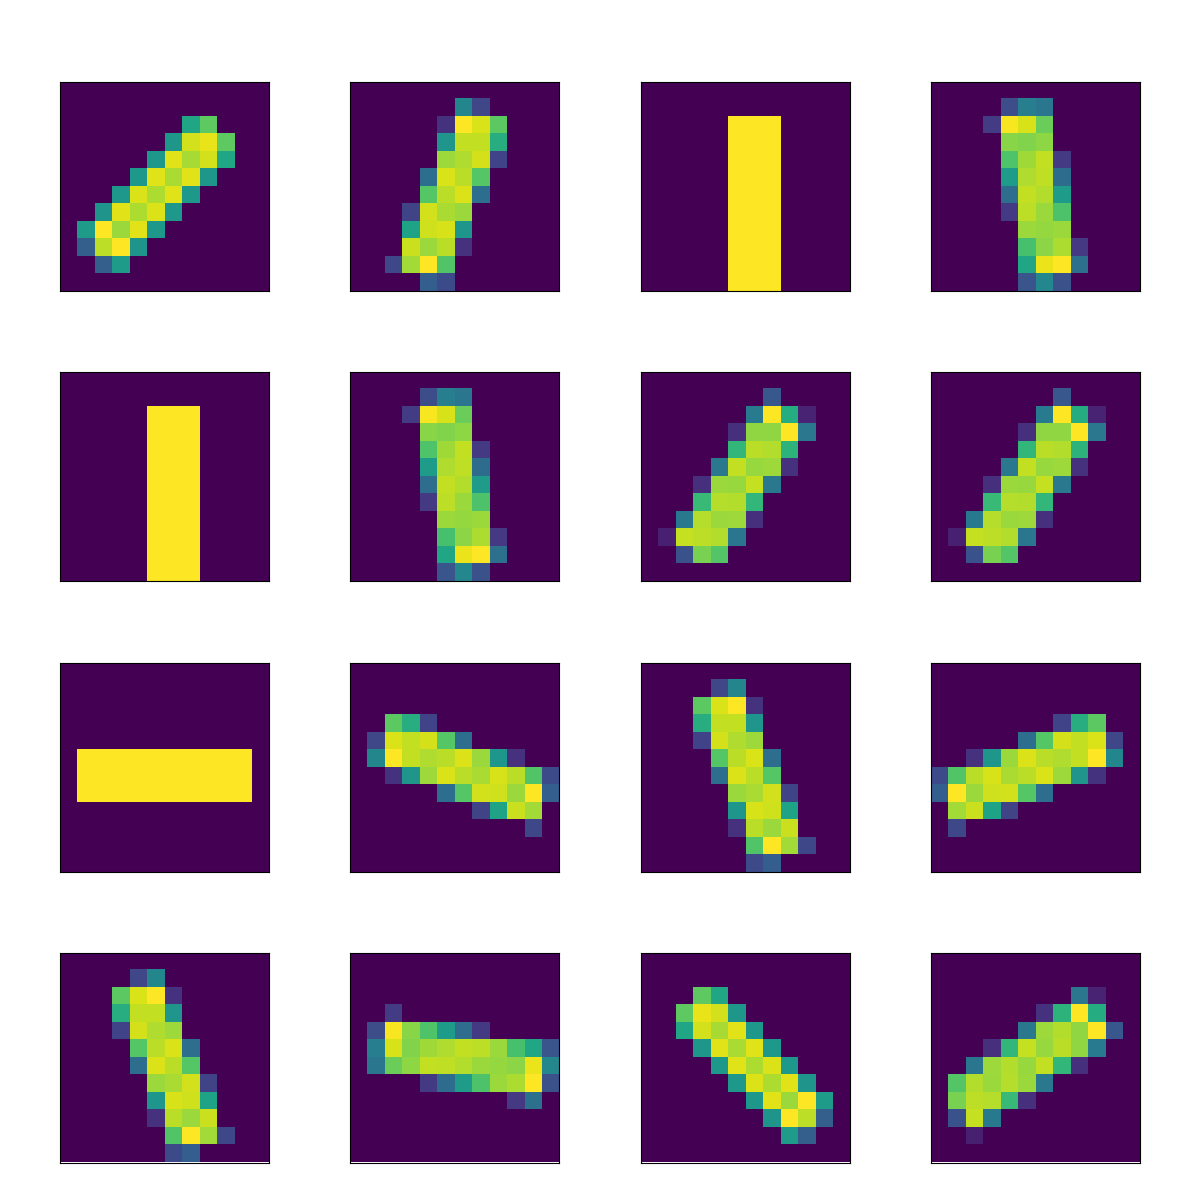

In [12]:
# Plot generated bars
shape = (12, 12)
bg = BarGenerator(shape)
num_samples = 16
bars, tags = bg.generate_samples(
    num_samples=num_samples,
    dim=(3, 10),
    shift=(0, 0),
    start_angle=0,
    step=180 / num_samples,
)
nrows, ncols = 4, 4
plt.close("all")
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 12))
for i in range(nrows):
    for j in range(ncols):
        index = i * nrows + j
        axs[i, j].imshow(bars[index])
        axs[i, j].set_title(rf"angle {tags[index]}$^\circ$", color="w")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
plt.tight_layout()

if os.path.isdir("figs"):
    filepath = os.path.join(plotpath, "bars.png")
    plt.savefig(filepath, dpi=600, transparent=True)